In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from datascience.utils_yose import  outliers_detection, QQPlot, log_transform, build_preprocessor, plot_hist_per_columns, plot_feature_correlations, make_features, predict_5pipeline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor as lgbm

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [260]:
train_data = "../data/train.csv"
test_data = "../data/test.csv"
df_train = pd.read_csv(train_data)

## Data Engineering

In [261]:
df_train = make_features(df_train)

## Pre - Process data

In [262]:
"""df_train_cat = df_train.select_dtypes(include=['object'])
try:
    df_train_cat_dummies = pd.get_dummies(df_train_cat, drop_first=True)
    for col in df_train_cat_dummies.columns:
        df_train_cat_dummies[col] = df_train_cat_dummies[col].astype(int)
except Exception:
    pass

df_train_num = df_train.select_dtypes(include=['float64', 'int64'])

df_train = pd.concat([df_train_num, df_train_cat_dummies], axis=1)
df_train.index = df_train.pop('Id')"""

"df_train_cat = df_train.select_dtypes(include=['object'])\ntry:\n    df_train_cat_dummies = pd.get_dummies(df_train_cat, drop_first=True)\n    for col in df_train_cat_dummies.columns:\n        df_train_cat_dummies[col] = df_train_cat_dummies[col].astype(int)\nexcept Exception:\n    pass\n\ndf_train_num = df_train.select_dtypes(include=['float64', 'int64'])\n\ndf_train = pd.concat([df_train_num, df_train_cat_dummies], axis=1)\ndf_train.index = df_train.pop('Id')"

In [263]:
X = df_train.drop("SalePrice", axis=1)
y = df_train["SalePrice"]
y = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = build_preprocessor(X_train)
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)



try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feat_{i}" for i in range(X_train_proc.shape[1])]


df_train_processed = pd.DataFrame(
    X_train_proc,
    columns=feature_names,
    index=X_train.index
)

# Agregar la y como columna
df_train_processed["SalePrice"] = y_train.values

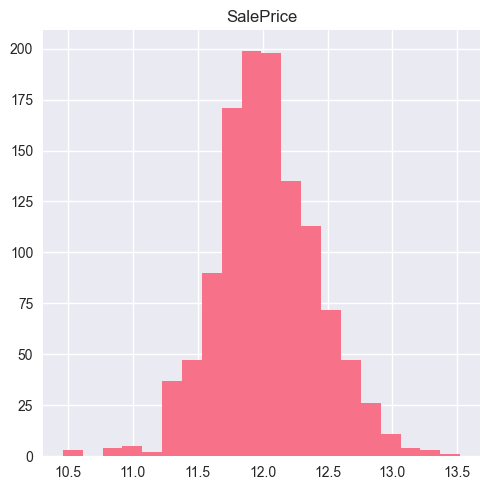

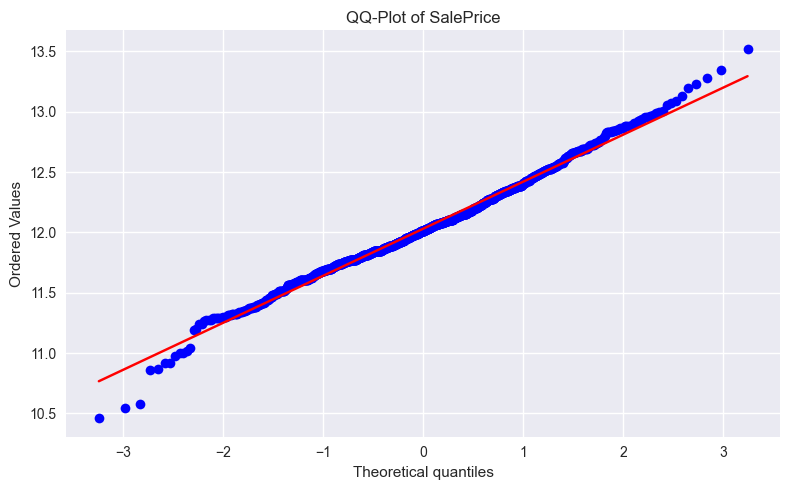

In [264]:
plot_hist_per_columns(df_train_processed, 'SalePrice')
QQPlot(df_train_processed['SalePrice'])

In [265]:
df_train_processed['SalePrice'] = log_transform(df_train_processed['SalePrice'])

### Post Log transform

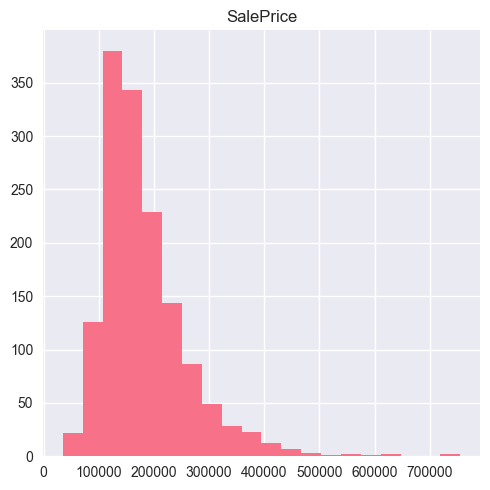

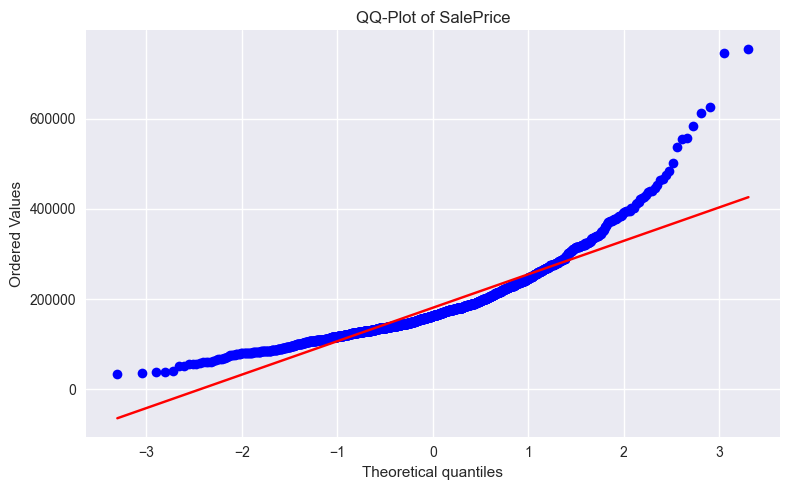

In [266]:
plot_hist_per_columns(df_train, 'SalePrice')
QQPlot(df_train['SalePrice'])

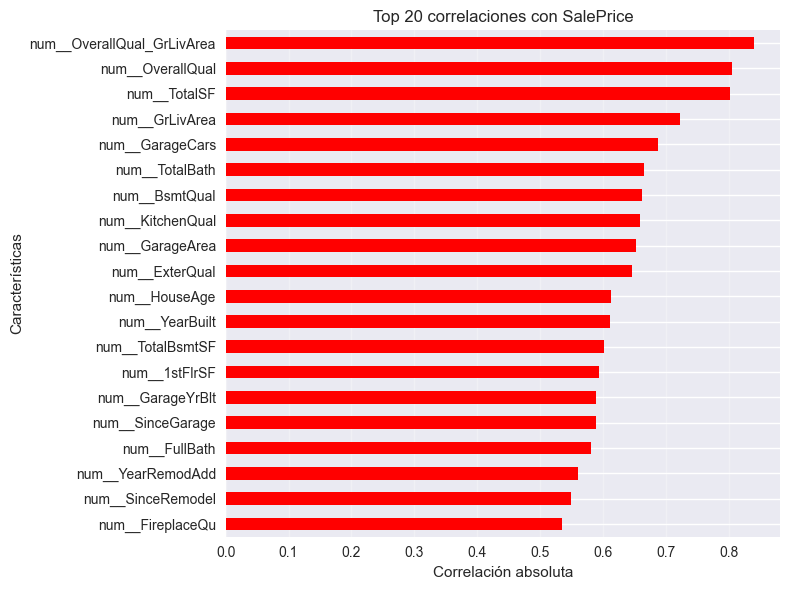

In [267]:
corr = df_train_processed.corr()['SalePrice'].sort_values(ascending=False).drop('SalePrice')
corr_abs = corr.abs().sort_values(ascending=False)
corr_abs_selected = corr_abs[corr_abs > 0.5]

plot_feature_correlations(df_train_processed.drop('SalePrice', axis=1), df_train_processed['SalePrice']);

In [268]:
for col in corr_abs_selected.index:
    outliers_vals = outliers_detection(df_train_processed[col])
    if outliers_vals:
        mask = df_train_processed[col].isin(outliers_vals)
        df_train_processed.loc[mask, col] = df_train_processed[col].median()

sp_outliers = outliers_detection(df_train['SalePrice'])
if sp_outliers:
    sp_mask = df_train_processed['SalePrice'].isin(sp_outliers)
    df_train_processed.loc[sp_mask, 'SalePrice'] = df_train_processed['SalePrice'].median()

print("Outliers encontrados y tratados con la mediana.")

Outliers encontrados y tratados con la mediana.


In [269]:
df_train_processed['SalePrice'].mean()

np.float64(2.566856390406571)

In [270]:
print("Mean of SalesPrice:",float(np.exp(df_train_processed['SalePrice']).mean()))
print("Standard Deviation of SalesPrice:",float(np.exp(df_train_processed['SalePrice']).std()))

Mean of SalesPrice: 13.030658310971575
Standard Deviation of SalesPrice: 0.39060602031704306


## OLS

In [271]:
X_ = sm.add_constant(X_train_proc)
model = sm.OLS(y_train, X_train_proc).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     67.81
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:58   Log-Likelihood:                 1144.0
No. Observations:                1168   AIC:                            -1808.
Df Residuals:                     928   BIC:                            -592.8
Df Model:                         239                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008      0.003      0.226      0.8

In [272]:
columnas_significativas = model.pvalues < 0.05 
columnas_significativas = columnas_significativas[columnas_significativas].index

## Ridge

In [273]:
np.random.seed(42)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_proc, y_train)

y_pred = ridge.predict(X_test_proc)

print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: % 5f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: %.5f" % r2_score(y_test, y_pred))

Mean squared error: 0.01577
Root mean squared error:  0.125565
Coefficient of determination: 0.91551


### Cross - Validation

In [274]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-3, 3, 10))
ridge.fit(X_train_proc, y_train)
ridge.alpha_

y_pred = ridge.predict(X_test_proc)

print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: % 5f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: %.5f" % r2_score(y_test, y_pred))

Mean squared error: 0.01692
Root mean squared error:  0.130076
Coefficient of determination: 0.90933


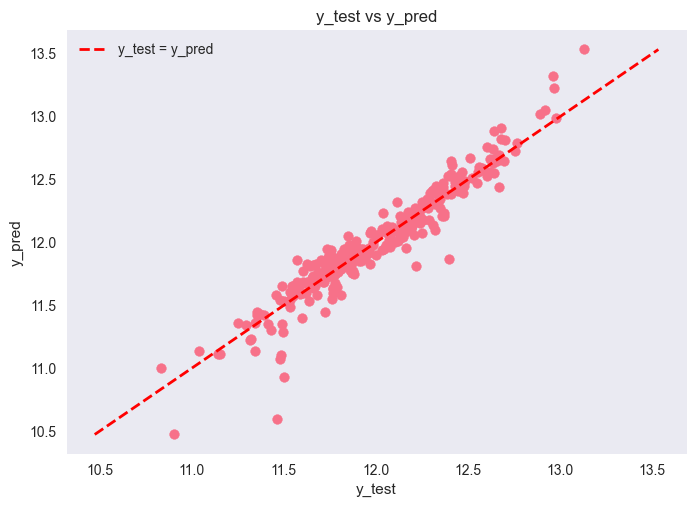

In [275]:
plt.scatter(y_pred, y_test) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='y_test = y_pred')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_test vs y_pred')
plt.grid()
plt.legend()
plt.show()

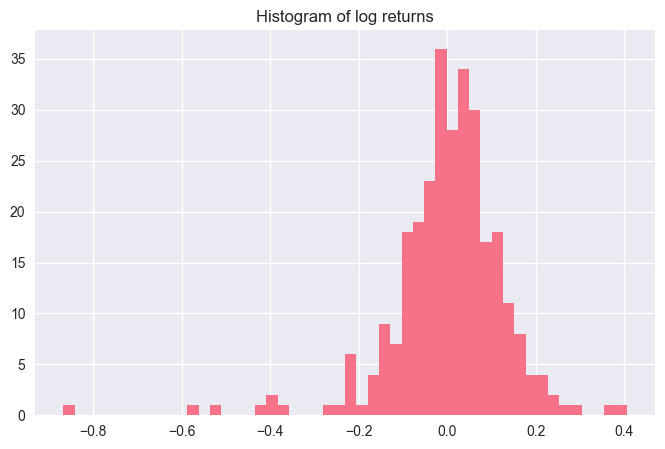

In [276]:
log_returns = pd.DataFrame(columns=['log_returns'], index= y_test.index)
log_returns['log_returns'] = y_test - y_pred

plt.figure(figsize=(8,5))
plt.hist(log_returns, bins=50)
plt.title('Histogram of log returns')
plt.grid(1)
plt.show()

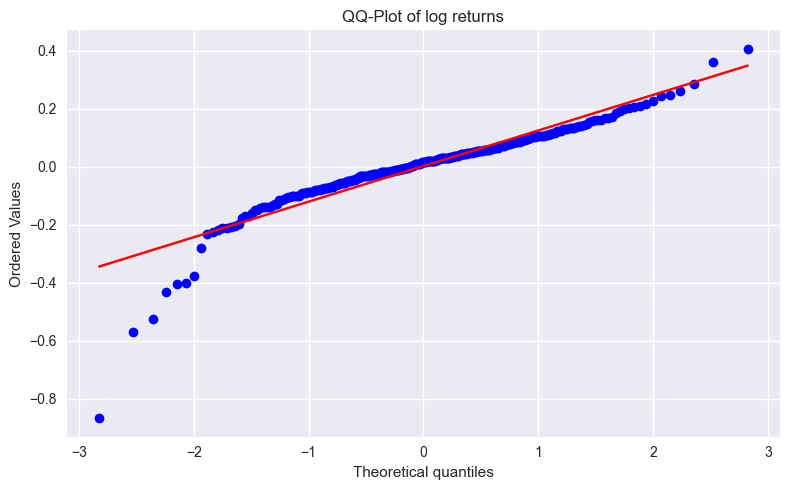

In [277]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

serie = np.asarray(log_returns).ravel()
serie = serie[~np.isnan(serie)]

plt.figure(figsize=(8,5))
stats.probplot(serie, dist='norm', plot=plt)
plt.grid(True)
plt.title('QQ-Plot of log returns')
plt.tight_layout()
plt.show()

## Random Forest Regressor

In [278]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(["SalePrice", 'Id'], axis=1), y, test_size=0.2, random_state=42)
pre = build_preprocessor(X_train)
pre.fit(X_train)

X_train = pre.transform(X_train)
X_valid = pre.transform(X_valid)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)

print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: % 5f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: %.5f" % r2_score(y_test, y_pred))

Mean squared error: 0.02115
Root mean squared error:  0.145429
Coefficient of determination: 0.88666


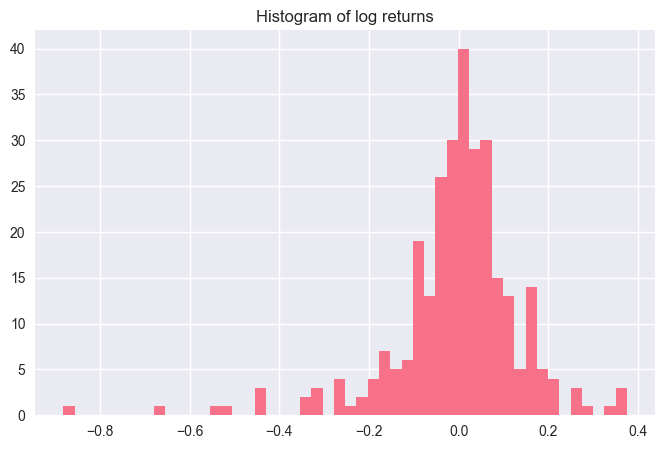

In [279]:
log_returns = pd.DataFrame(columns=['log_returns'], index= y_test.index)
log_returns['log_returns'] = y_test - y_pred

log_returns_no_outliers = log_returns[~log_returns['log_returns'].isin(outliers_detection(log_returns['log_returns']))]

plt.figure(figsize=(8,5))
plt.hist(log_returns, bins=50)
plt.title('Histogram of log returns')
plt.grid(1)
plt.show()

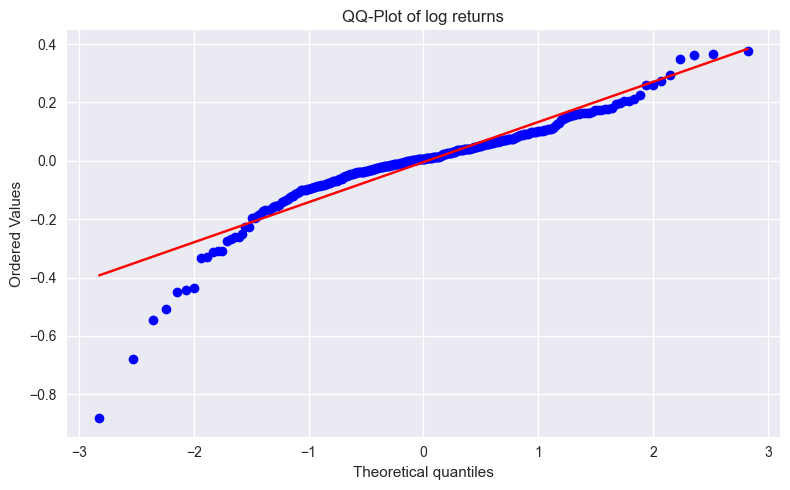

In [280]:
serie = np.asarray(log_returns).ravel()
serie = serie[~np.isnan(serie)]

plt.figure(figsize=(8,5))
stats.probplot(serie, dist='norm', plot=plt)
plt.grid(True)
plt.title('QQ-Plot of log returns')
plt.tight_layout()
plt.show()

# Submission RandomForest

In [281]:
# df_submission = pd.read_csv(test_data, index_col="Id")

# X_submit_fe = make_features(df_submission.copy())

# X_submit_fe = X_submit_fe.assign(Id=X_submit_fe.index)

# X_submit_proc = preprocessor.transform(X_submit_fe)

# y_pred_submission = rf.predict(X_submit_proc)
# y_pred_submission = np.expm1(y_pred_submission)

# submission = pd.DataFrame({"Id": df_submission.index, "SalePrice": y_pred_submission})
# submission.to_csv("submission.csv", index=False)

In [282]:
# id = df_submission.index.to_numpy().astype(int) 

# df_submission = pd.DataFrame({'Id': id, 'SalePrice': y_pred_submission})
# df_submission.to_csv('../data/submissionRF.csv', index=False)
# df_submission

## Submission pipeline with 3 models

In [ ]:



df_submission_3p = pd.read_csv(test_data, index_col="Id")

X_submit_fe_3p = make_features(df_submission_3p.copy())
X_submit_fe_3p = X_submit_fe_3p.assign(Id=X_submit_fe_3p.index)

pred_lasso_3p = best_pipe_lasso.predict(X_submit_fe_3p)
pred_rf_3p    = best_pipe_rf.predict(X_submit_fe_3p)
pred_lgbm_3p  = best_pipe_lgbm.predict(X_submit_fe_3p)

y_pred_submission_3p = (pred_lasso_3p + pred_rf_3p + pred_lgbm_3p) / 3

y_pred_submission_3p = np.expm1(y_pred_submission_3p)

submission_3p = pd.DataFrame({
    "Id": df_submission_3p.index,
    "SalePrice": y_pred_submission_3p
})
submission_3p.to_csv("submission.csv", index=False)

submission_alt_3p = submission_3p.copy()
submission_alt_3p["Id"] = submission_alt_3p["Id"].astype(int)
submission_alt_3p.to_csv("../data/submission3pipes.csv", index=False)

print(submission_3p.head())

     Id    SalePrice
0  1461 120550.08681
1  1462 159698.63040
2  1463 184457.34587
3  1464 190116.49594
4  1465 195797.43970


## Pipeline 2 models

In [ ]:
# xgb_model = xgb.XGBRegressor( booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
#              importance_type='gain', learning_rate=0.01, max_delta_step=0,
#              max_depth=4, min_child_weight=1.5, n_estimators=2400,
#              n_jobs=1, nthread=None, objective='reg:linear',
#              reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
#              silent=None, subsample=0.8, verbosity=1)


# lgbm_model = lgbm(objective='regression', 
#                                        num_leaves=4,
#                                        learning_rate=0.01, 
#                                        n_estimators=12000, 
#                                        max_bin=200, 
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5, 
#                                        bagging_seed=7,
#                                        feature_fraction=0.4, 
#                                        )

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# rmse_scores = []
# r2_scores = []
# trained_models = []

# for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
#     X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
#     y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

#     pre_fold = build_preprocessor(X_train_fold)
#     pre_fold.fit(X_train_fold)

#     pipe_xgb_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", xgb_model)
#     ])
    
#     pipe_lgbm_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", lgbm_model)
#     ])
    
#     pipe_xgb_fold.fit(X_train_fold, y_train_fold)
#     pipe_lgbm_fold.fit(X_train_fold, y_train_fold)
    
#     y_pred_valid_fold_xgb = pipe_xgb_fold.predict(X_valid_fold)
#     y_pred_valid_fold_lgbm = pipe_lgbm_fold.predict(X_valid_fold)
#     y_pred_valid_fold = ( y_pred_valid_fold_xgb*0.45 + y_pred_valid_fold_lgbm * 0.55)

#     rmse_scores.append(np.sqrt(mean_squared_error(y_valid_fold, y_pred_valid_fold)))
#     r2_scores.append(r2_score(y_valid_fold, y_pred_valid_fold))

#     trained_models.append({
#         "fold": fold,
#         "xgb": pipe_xgb_fold,
#         "lgbm": pipe_lgbm_fold
#     })

# # best models
# best_fold_index = np.argmin(rmse_scores)
# best_rmse = rmse_scores[best_fold_index]
# best_r2 = r2_scores[best_fold_index]

# best_models = trained_models[best_fold_index]
# best_pipe_xgb = best_models['xgb']
# best_pipe_lgbm = best_models['lgbm']

# print("\n---")
# print(f"Mejor fold: {best_fold_index + 1}")
# print(f"RMSE del mejor fold: {best_rmse:,.5f}")
# print(f"R2 del mejor fold  : {best_r2:.5f}")
# print("\nLos modelos del mejor fold fueron guardados en las variables 'best_pipe_xgb' y 'best_pipe_lgbm'.")

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3617
[LightGBM] [Info] Number of data point

### Submission 2 models

In [ ]:
# df_submission_2p = pd.read_csv(test_data, index_col="Id")

# X_submit_fe_2p = make_features(df_submission_2p.copy())
# X_submit_fe_2p = X_submit_fe_2p.assign(Id=X_submit_fe_2p.index)

# y_pred_submission_2p = (best_pipe_xgb.predict(X_submit_fe_2p) * 0.45 + best_pipe_lgbm.predict(X_submit_fe_2p) * 0.55)

# y_pred_submission_2p = np.expm1(y_pred_submission_2p)

# submission_2p = pd.DataFrame({
#     "Id": df_submission_2p.index,
#     "SalePrice": y_pred_submission_2p
# })


# submission_alt_2p = submission_2p.copy()
# submission_alt_2p["Id"] = submission_alt_2p["Id"].astype(int)
# submission_alt_2p.to_csv("../data/submission2pipes.csv", index=False)

# print(submission_alt_2p.head())

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
     Id    SalePrice
0  1461 106220.17262
1  1462 153253.51438
2  1463 160404.38840
3  1464 188507.36719
4  1465 172182.11739


## Pipeline 5 models

In [ ]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# rmse_scores = []
# r2_scores = []
# trained_models = []

# for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
#     X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
#     y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

#     pre_fold = build_preprocessor(X_train_fold)
#     pre_fold.fit(X_train_fold)

#     pipe_lasso_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", Lasso(alpha=0.0005, max_iter=5000, random_state=42))
#     ])
#     pipe_rf_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", RandomForestRegressor(
#             n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1
#         ))
#     ])
#     pipe_lgbm_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", lgbm(
#             n_estimators=3000, learning_rate=0.03, max_depth=-1,
#             num_leaves=31, subsample=0.8, colsample_bytree=0.8,
#             random_state=42, n_jobs=-1
#         ))
#     ])
#     pipe_xgb_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", xgb.XGBRegressor(
#             n_estimators=3000, learning_rate=0.03, max_depth=6,
#             subsample=0.8, colsample_bytree=0.8,
#             random_state=42, n_jobs=-1
#         ))
#     ])
#     pipe_cat_fold = Pipeline([
#         ("pre", clone(pre_fold)),
#         ("model", CatBoostRegressor(
#             n_estimators=3000, learning_rate=0.03,
#             subsample=0.8,
#             random_state=42, verbose=0
#         ))
#     ])

#     pipe_lasso_fold.fit(X_train_fold, y_train_fold)
#     pipe_rf_fold.fit(X_train_fold, y_train_fold)
#     pipe_lgbm_fold.fit(X_train_fold, y_train_fold)
#     pipe_xgb_fold.fit(X_train_fold, y_train_fold)
#     pipe_cat_fold.fit(X_train_fold, y_train_fold)

#     p_lasso_fold = pipe_lasso_fold.predict(X_valid_fold)
#     p_rf_fold    = pipe_rf_fold.predict(X_valid_fold)
#     p_lgbm_fold  = pipe_lgbm_fold.predict(X_valid_fold)
#     p_xgb_fold   = pipe_xgb_fold.predict(X_valid_fold)
#     p_cat_fold   = pipe_cat_fold.predict(X_valid_fold)

#     p_ens_fold = (p_lasso_fold + p_rf_fold + p_lgbm_fold + p_xgb_fold + p_cat_fold) / 5

#     rmse_fold = np.sqrt(mean_squared_error(y_valid_fold, p_ens_fold))
#     r2_fold = r2_score(y_valid_fold, p_ens_fold)
    
#     rmse_scores.append(rmse_fold)
#     r2_scores.append(r2_fold)

#     trained_models.append({
#         'lasso': pipe_lasso_fold,
#         'rf': pipe_rf_fold,
#         'lgbm': pipe_lgbm_fold,
#         'xgb': pipe_xgb_fold,
#         'cat': pipe_cat_fold
#     })

#     print(f"Fold {fold+1}: RMSE = {rmse_fold:,.5f}, R2 = {r2_fold:.5f}")

# best_fold_index = np.argmin(rmse_scores)
# best_rmse = rmse_scores[best_fold_index]
# best_r2 = r2_scores[best_fold_index]

# best_models = trained_models[best_fold_index]
# best_pipe_lasso = best_models['lasso']
# best_pipe_rf = best_models['rf']
# best_pipe_lgbm = best_models['lgbm']
# best_pipe_xgb = best_models['xgb']
# best_pipe_cat = best_models['cat']

# print("\n---")
# print(f"Mejor fold: {best_fold_index + 1}")
# print(f"RMSE del mejor fold: {best_rmse:,.5f}")
# print(f"R2 del mejor fold  : {best_r2:.5f}")

### 5 pipeline Submission

In [ ]:
# df_submission_5p = pd.read_csv(test_data, index_col="Id")

# X_submit_fe_5p = make_features(df_submission_5p.copy())
# X_submit_fe_5p = X_submit_fe_5p.assign(Id=X_submit_fe_5p.index)

# y_pred_submission_5p = predict_5pipeline(best_models, X_submit_fe_5p)

# y_pred_submission_5p = np.expm1(y_pred_submission_5p)

# submission_5p = pd.DataFrame({
#     "Id": df_submission_5p.index,
#     "SalePrice": y_pred_submission_5p
# })

# submission_5p.to_csv("../data/submission5p.csv", index=False)

# submission_alt_5p = submission_5p.copy()
# submission_alt_5p["Id"] = submission_alt_5p["Id"].astype(int)
# submission_alt_5p.to_csv("../data/submission5pipes.csv", index=False)

# print(submission_alt_5p.head())

     Id    SalePrice
0  1461 122628.85727
1  1462 159785.96825
2  1463 184131.27921
3  1464 193569.95276
4  1465 194678.29966
